In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Network architecture:


**Goal**: the predict the x-y co-ordinates of the top and bottom layer hits from the calorimeter images, the total deposited energy, and the maxEbar energy. 

Since we are dealing with images, the natural choice is to train a CNN. As a first pass, let us train a simple CNN with the images and the energy deposits

Let's load the preprocessed data

In [2]:
unzip_data = np.load("data/preprocessed_scaled_data_v2.npz")
calorimeter_images, calorimeter_data, data_target = unzip_data['arr_0'], unzip_data['arr_1'], unzip_data['arr_2']

In [3]:
N_CHANNELS = 22
N_LAYERS = 14

As a sanity check, let's plot a couple of images

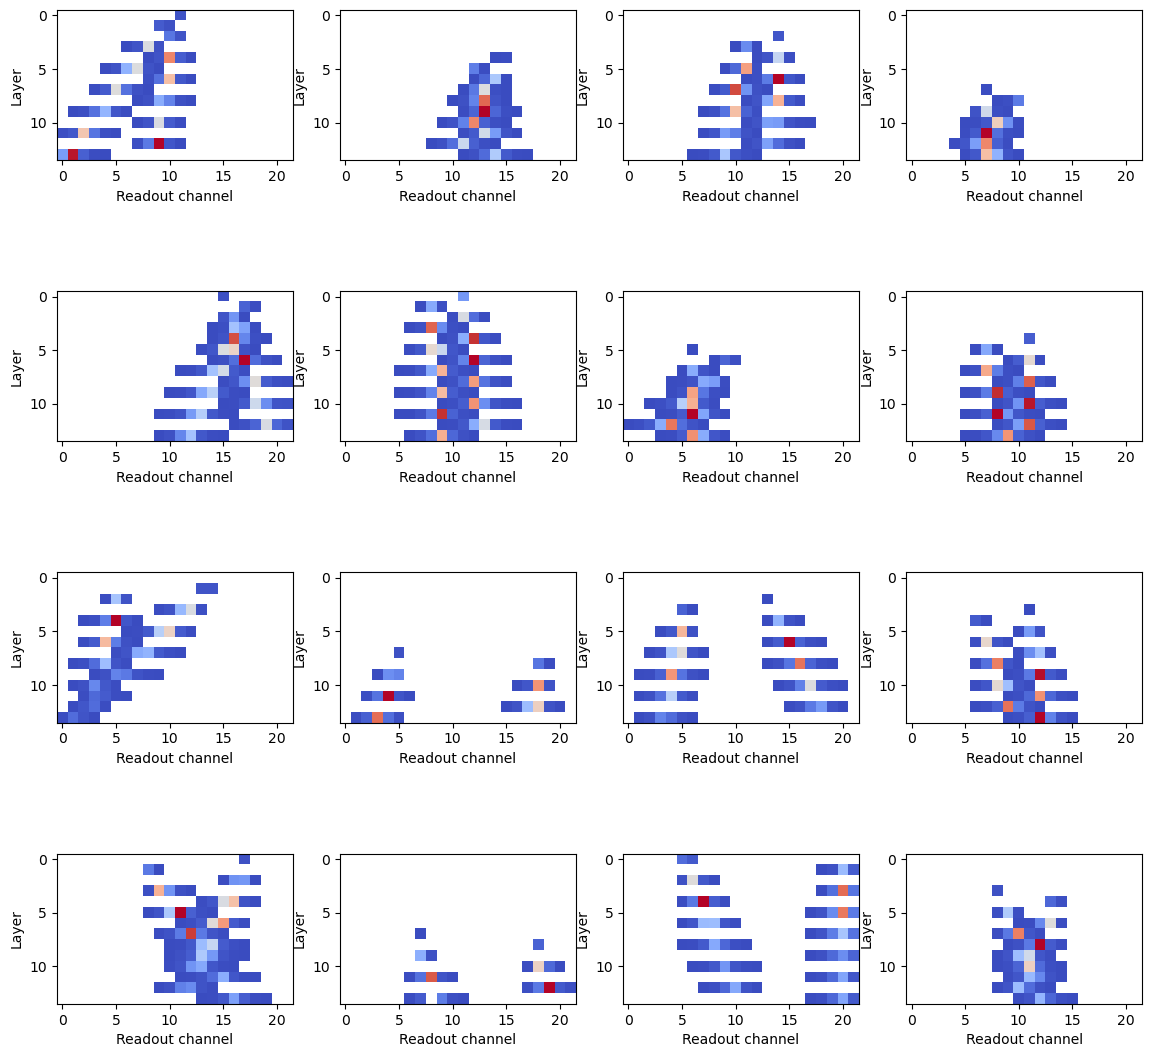

In [4]:
n_c = 4
n_r = 4
fig, ax = plt.subplots(n_c, n_r, figsize=(14, 14))
for i, ax in enumerate(fig.axes):
    # Here we make a copy so we can manipulate the array without changing it in calorimeter_images
    image = calorimeter_images[i].copy()
    # Filling the zero values with NaNs will show us white space where there is zero deposits recorded.
    # Note that if we didn't have the copy there, this would insert NaNs into calorimeter_images.
    image[image == 0] = 'nan'
    ax.imshow(image, cmap="coolwarm")
    ax.set_xlabel("Readout channel")
    ax.set_ylabel("Layer")
plt.show()

In [ ]:
calorimeter_images.shape

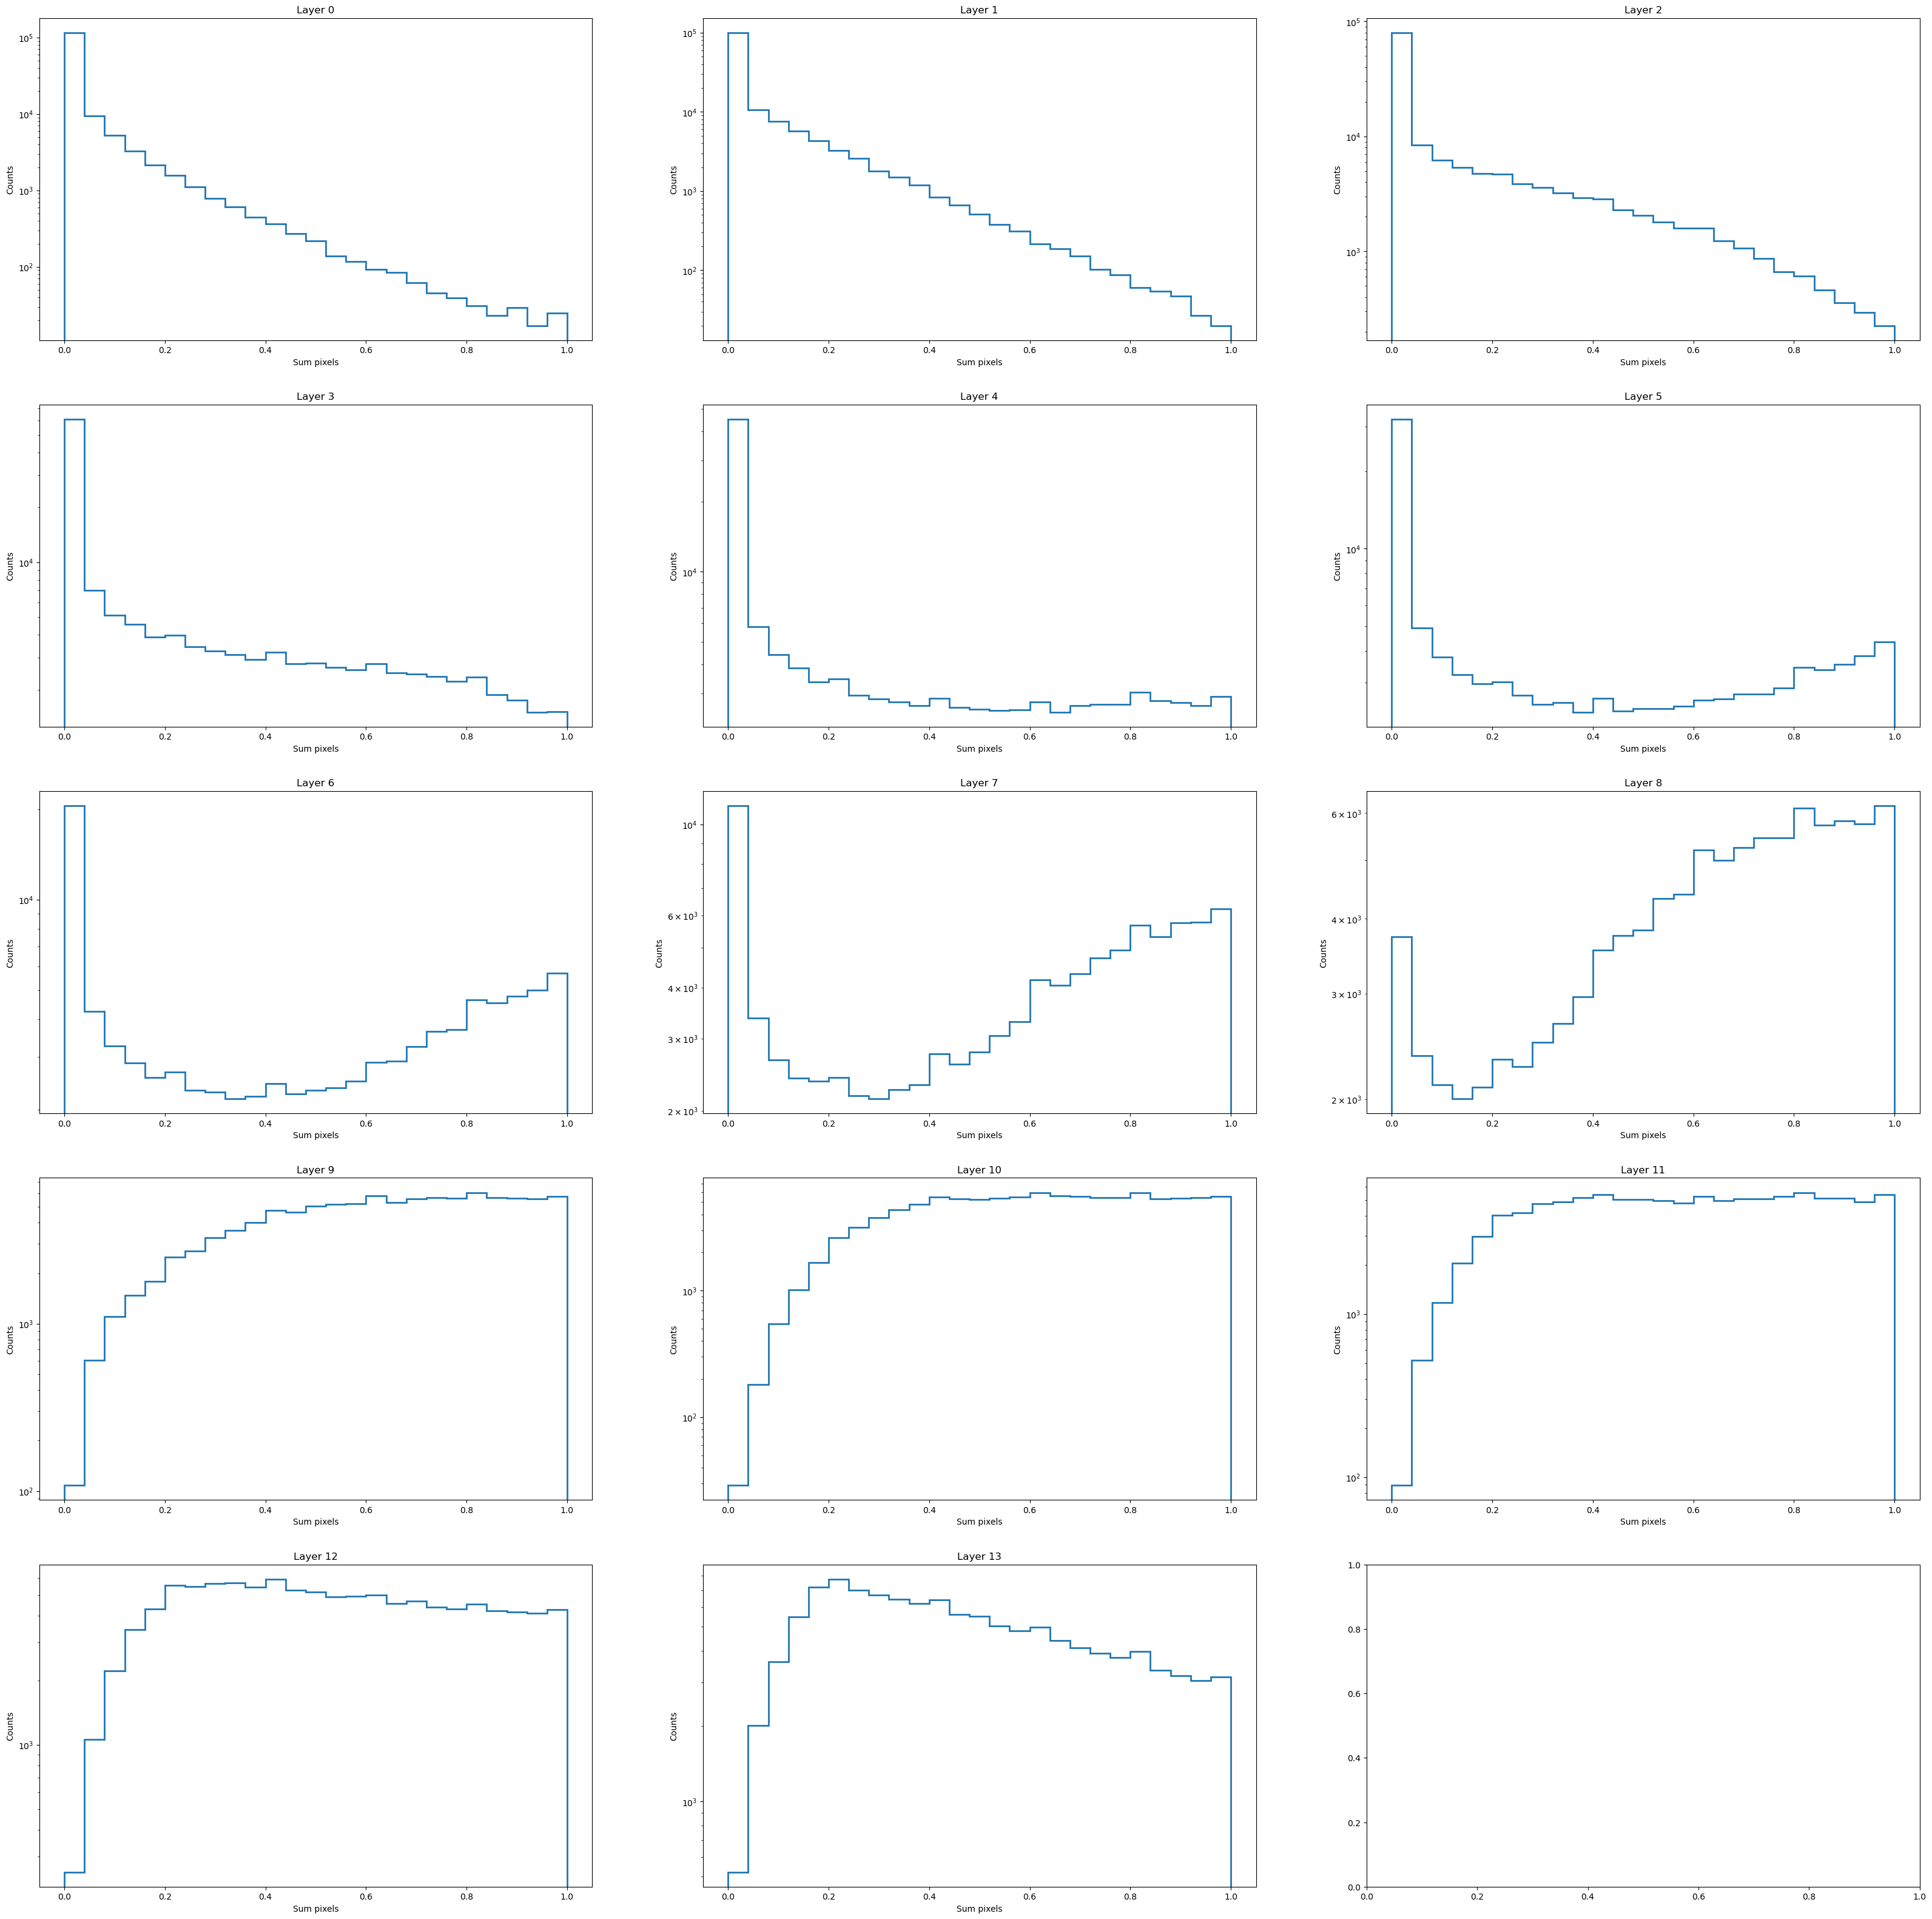

In [5]:
pixel_density = calorimeter_images[:,:,:,0]

sum_pixels_layer = pixel_density.sum(axis=2)

fig, _ = plt.subplots(5,3, figsize=(40,40))
axes = fig.axes

for i_layer in range(N_LAYERS):
    axes[i_layer].hist(sum_pixels_layer[:,i_layer], bins=np.linspace(0,1,26), histtype='step', linewidth=2)
    axes[i_layer].set_title(f"Layer {i_layer}")
    axes[i_layer].set_xlabel("Sum pixels")
    axes[i_layer].set_ylabel("Counts")
    axes[i_layer].semilogy()

plt.show()
fig.clf()

In [ ]:
sum_pixels_layer.shape

## Split the data into training and testing datasets

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
train_images, testing_images, train_energies, testing_energies, train_coords, testing_coords \
= train_test_split(calorimeter_images, calorimeter_data, data_target, train_size=0.3, shuffle=True)

In [8]:
test_images, trial_images, test_energies, trial_energies, test_coords, trial_coords \
= train_test_split(testing_images, testing_energies, testing_coords, test_size=0.2, shuffle=True)

## Set up a network

First, let us set up a CNN with just the images

In [17]:
import keras
from keras.layers import Conv2D, GlobalAveragePooling2D, GlobalMaxPooling2D, Concatenate, MaxPool2D
from keras.layers import Input, Dense, Flatten
from keras.models import Model

In [18]:
in_images = Input(shape=(N_LAYERS, N_CHANNELS, 1))
in_energies = Input(shape=(2,))

h = Conv2D(filters=32,
            kernel_size=(3,3),
            strides=(1,1),
            padding='same',
            data_format="channels_last",
            use_bias=True,
            activation="relu")(in_images)

h = Conv2D(filters=32,
            kernel_size=(3,3),
            strides=(1,1),
            padding='same',
            data_format="channels_last",
            use_bias=True,
            activation='relu')(h)

h = Conv2D(filters=64,
            kernel_size=(3,3),
            strides=(1,1),
            padding='same',
            data_format="channels_last",
            use_bias=True,           
            activation='relu')(h)

h = GlobalMaxPooling2D()(h)

h = Concatenate(axis=-1)([h, in_energies])

h = Flatten()(h)

h = Dense(units=128, activation='relu', use_bias=True)(h)

# h = Dense(units=, activation='relu', use_bias=True)(h)

outputs = Dense(units=4, activation='linear')(h)

model = Model(inputs=[in_images, in_energies], outputs=outputs)

In [19]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 14, 22, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 14, 22,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 14, 22,    │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 14, 22,    │     18,496 │ conv2d_1[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ conv2d_2[0][0]    │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 66)        │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 66)        │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │      8,576 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 4)         │        516 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 37,156 (145.14 KB)

 Trainable params: 37,156 (145.14 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
batchsize = 128
learning_rate = 0.01
num_epochs = 100
verbosity = 0

In [21]:
optimizer = tf.keras.optimizers.Adagrad(learning_rate=learning_rate)

In [22]:
model.compile(optimizer=optimizer, loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])

In [23]:
history = model.fit([train_images,train_energies], train_coords, 
                    epochs=num_epochs, verbose=verbosity,
                    batch_size=batchsize, validation_data=([test_images,test_energies], test_coords),
                    callbacks=tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                               patience=5,
                                                               restore_best_weights=True))

## Preliminary cross checks

In [24]:
import plotting

In [25]:
plotting.make_pretty_format()

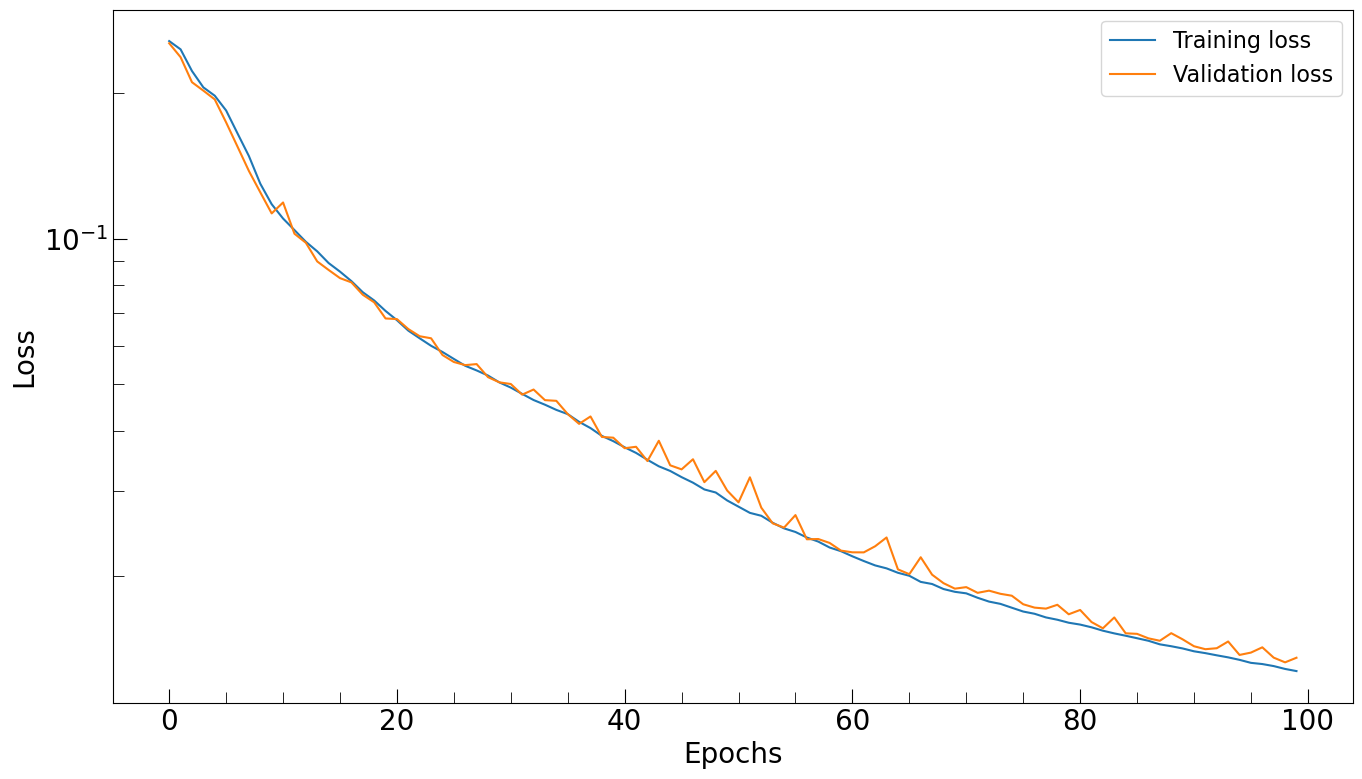

In [26]:
fig = plotting.plot_losses(history)

plt.minorticks_on()
plt.semilogy()

plt.show()
fig.clf()

### Predict the x-y co-ordinates for the test data

In [27]:
pred_coords = model.predict([trial_images,trial_energies], batch_size=500)

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step


### Plot the predicted-truth linearity

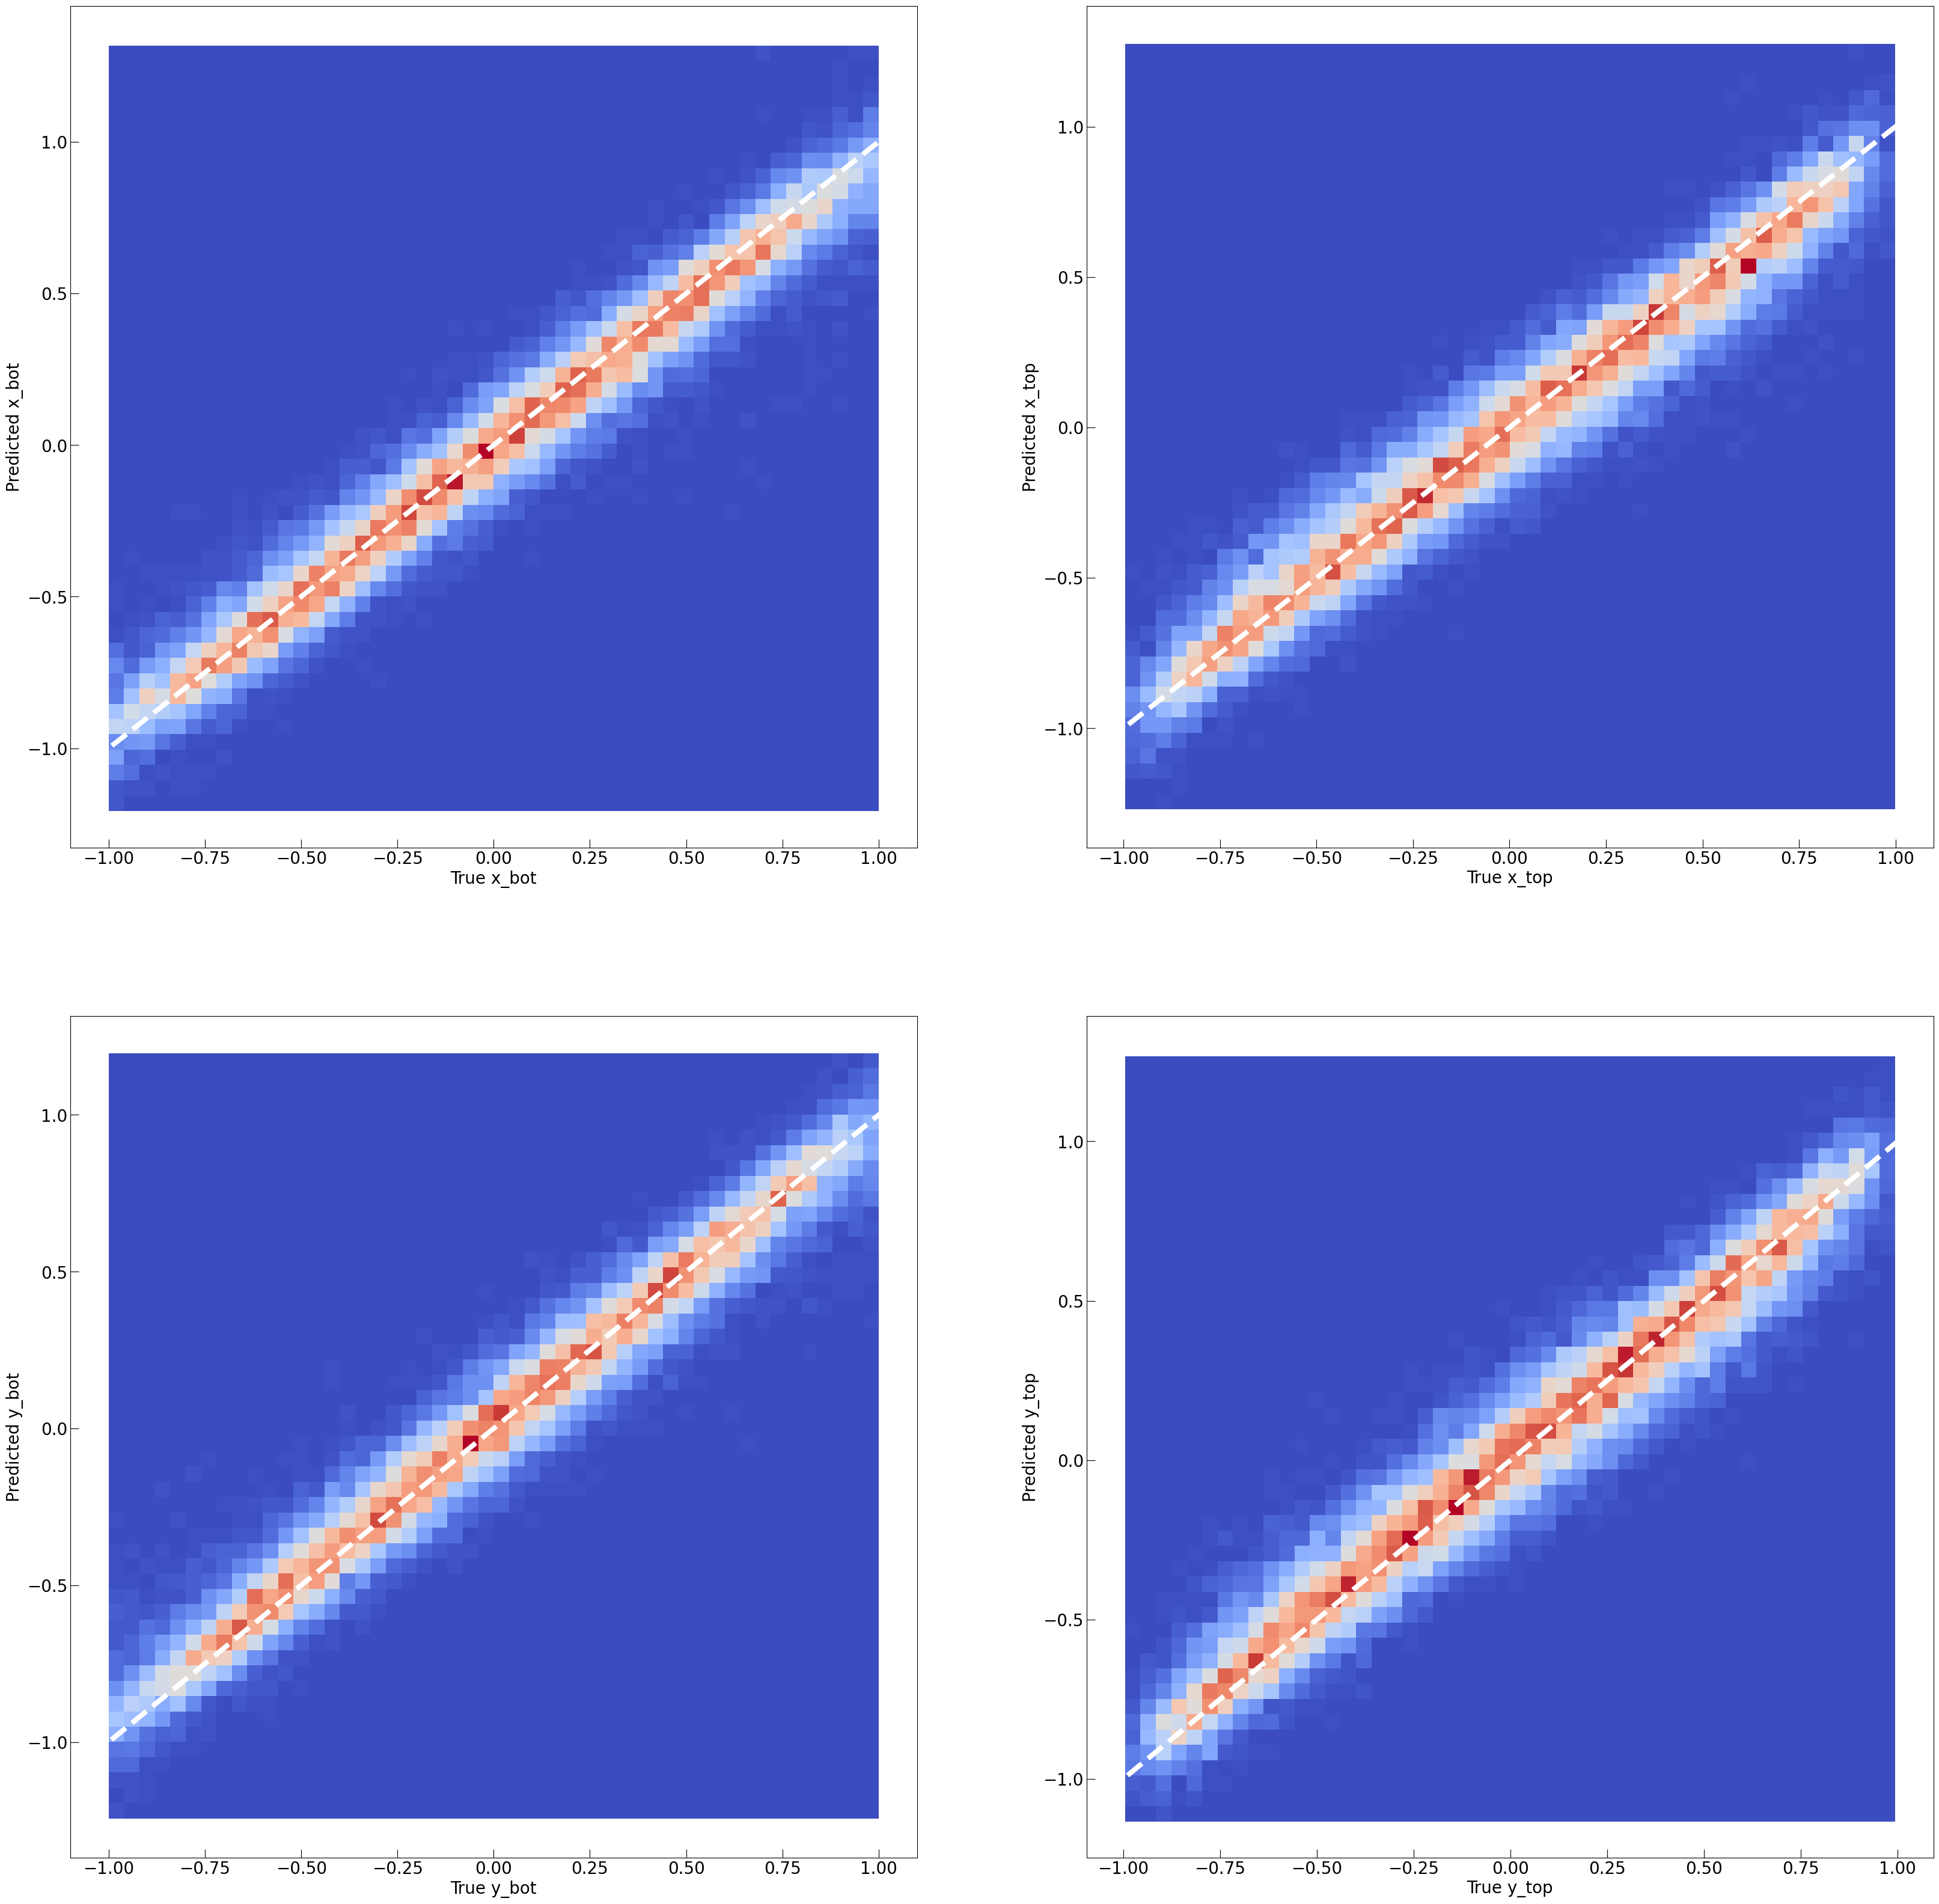

In [28]:
labels = ['x_bot', 'x_top', 'y_bot', 'y_top']

fig = plotting.plot_predictions(pred_coords, trial_coords, var_label=labels)

plt.show()
fig.clf()

### Plot the predicted - truth bias

/Users/devanshu/UniGe/final-project-dampe/plotting.py:19: RuntimeWarning: invalid value encountered in sqrt
  return (A / np.sqrt(sigma)) * np.exp(-1.0 * (x - mu)**2 / (2 * sigma**2))


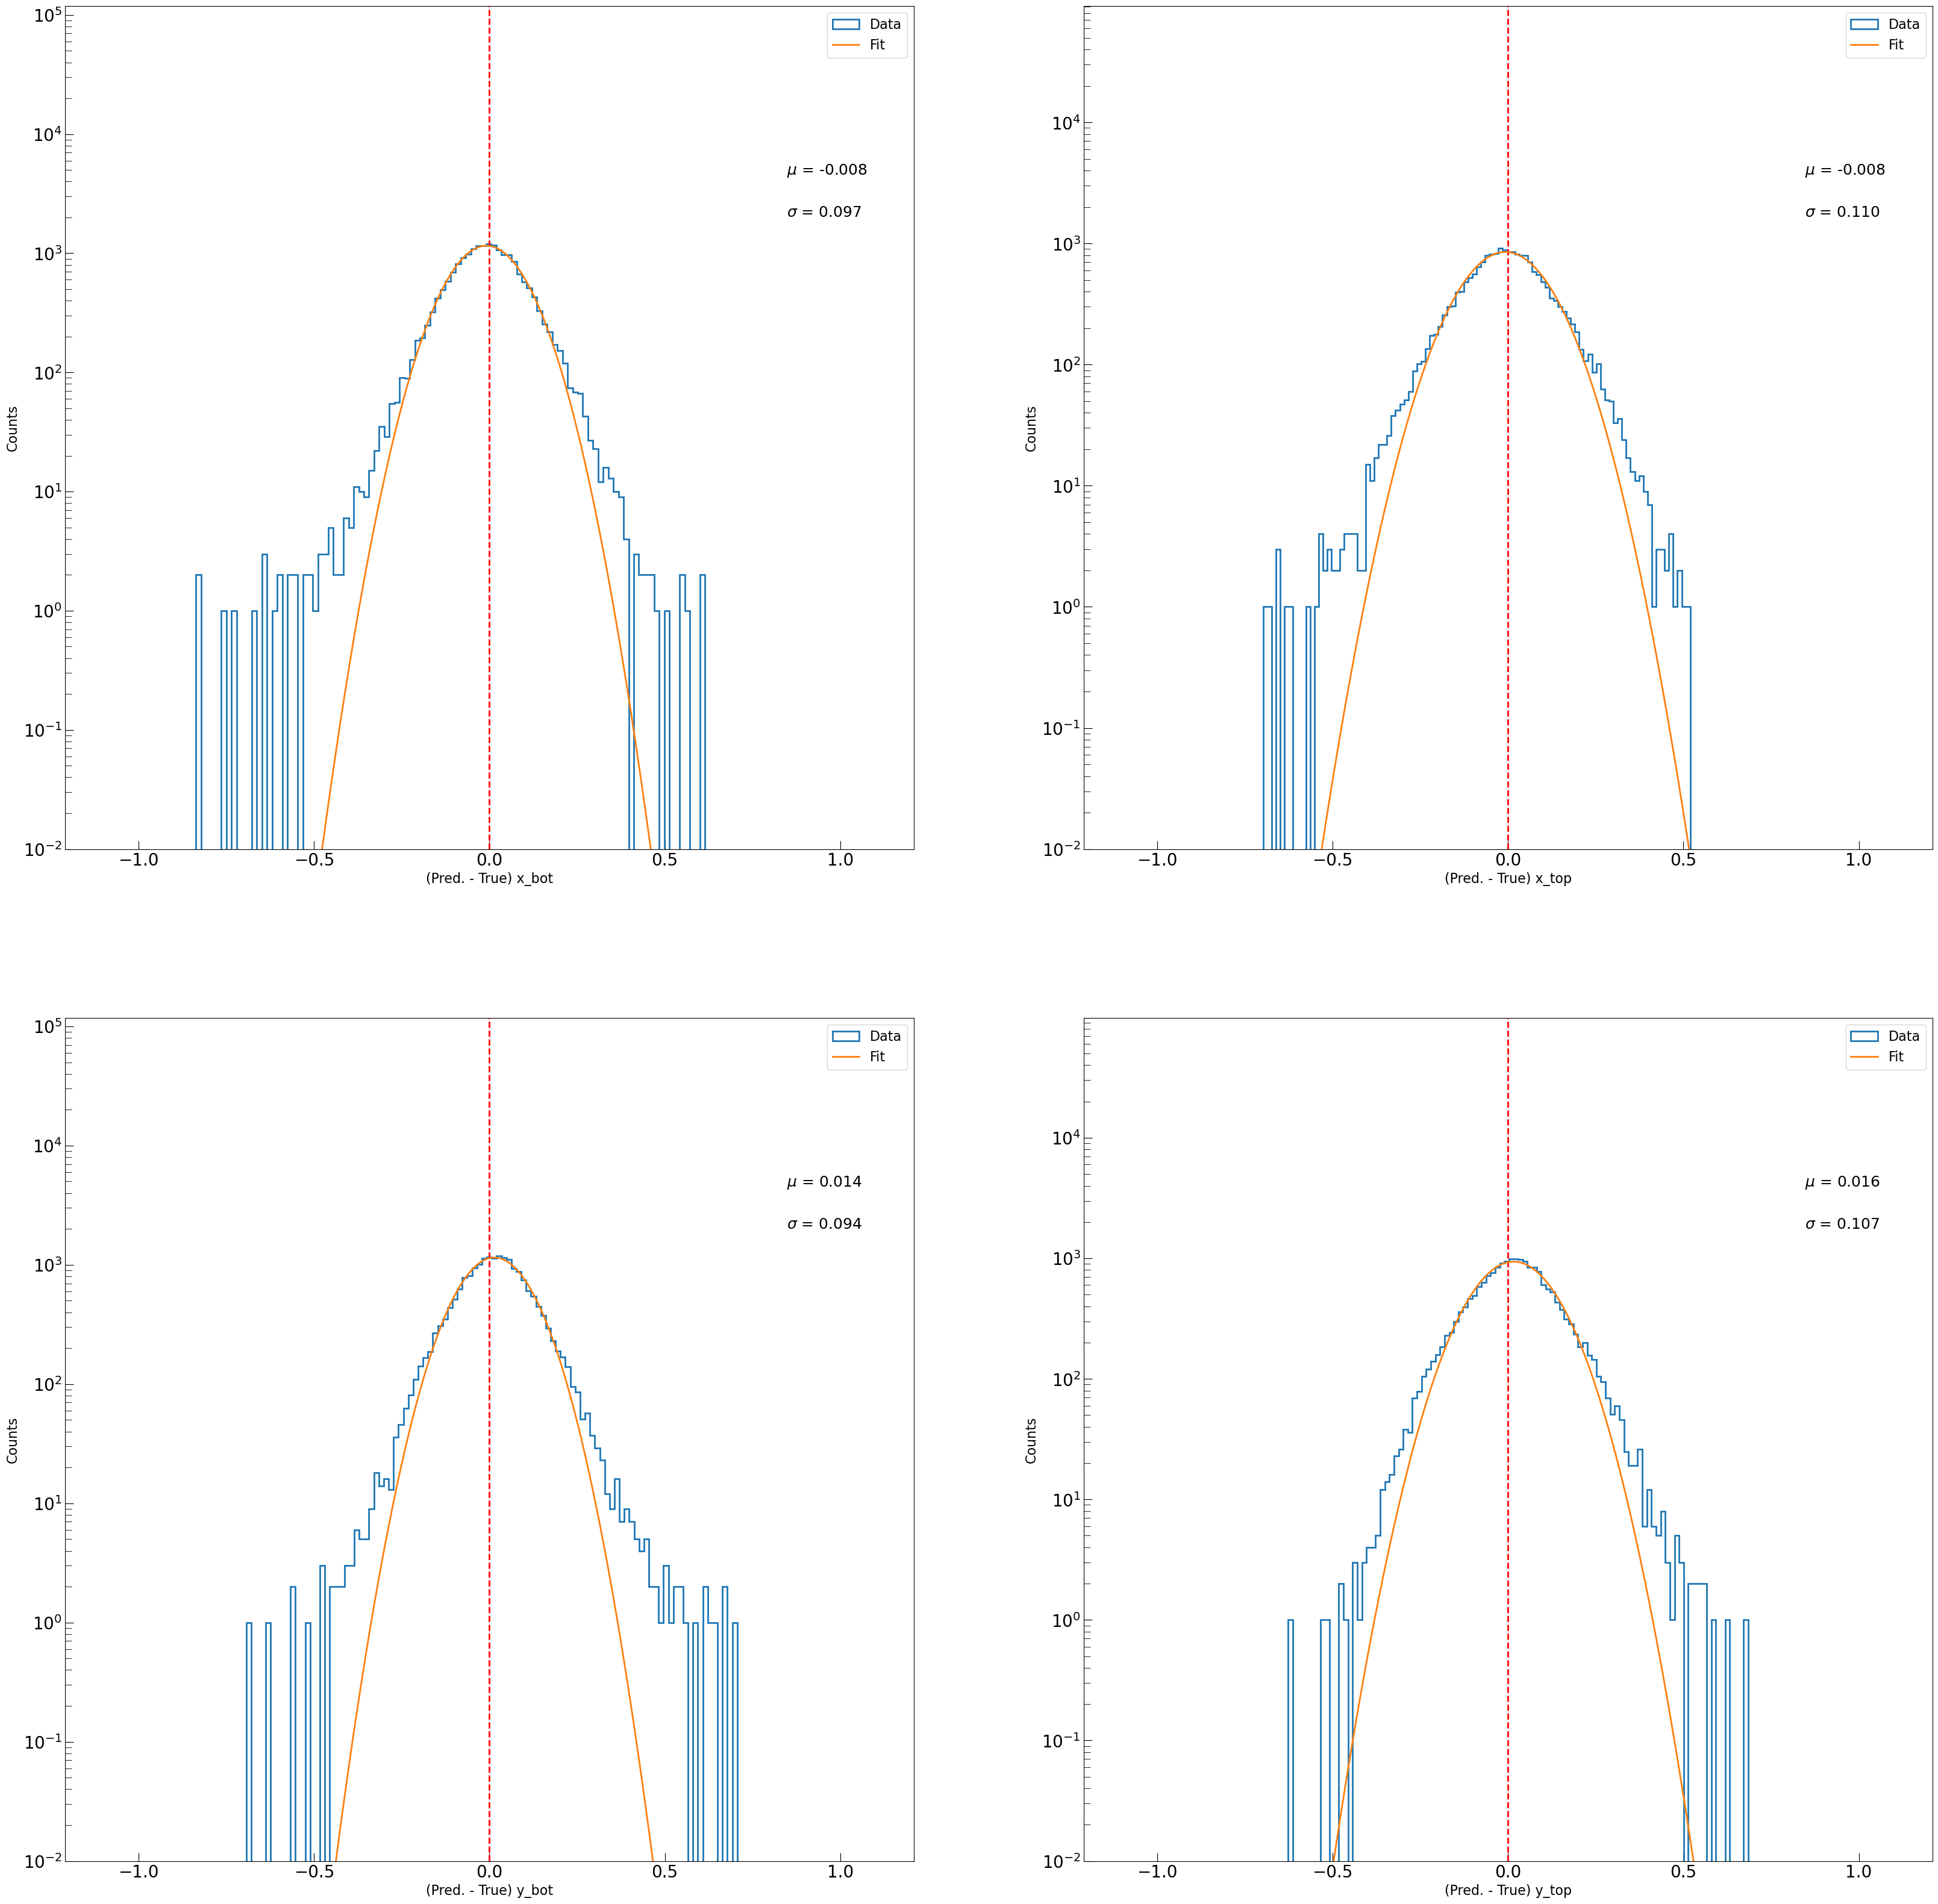

In [29]:
fig = plotting.plot_bias(pred_coords, trial_coords, var_label=labels, fit_bias=True)

plt.show()
fig.clf()

### Plot the bias vs. truth 

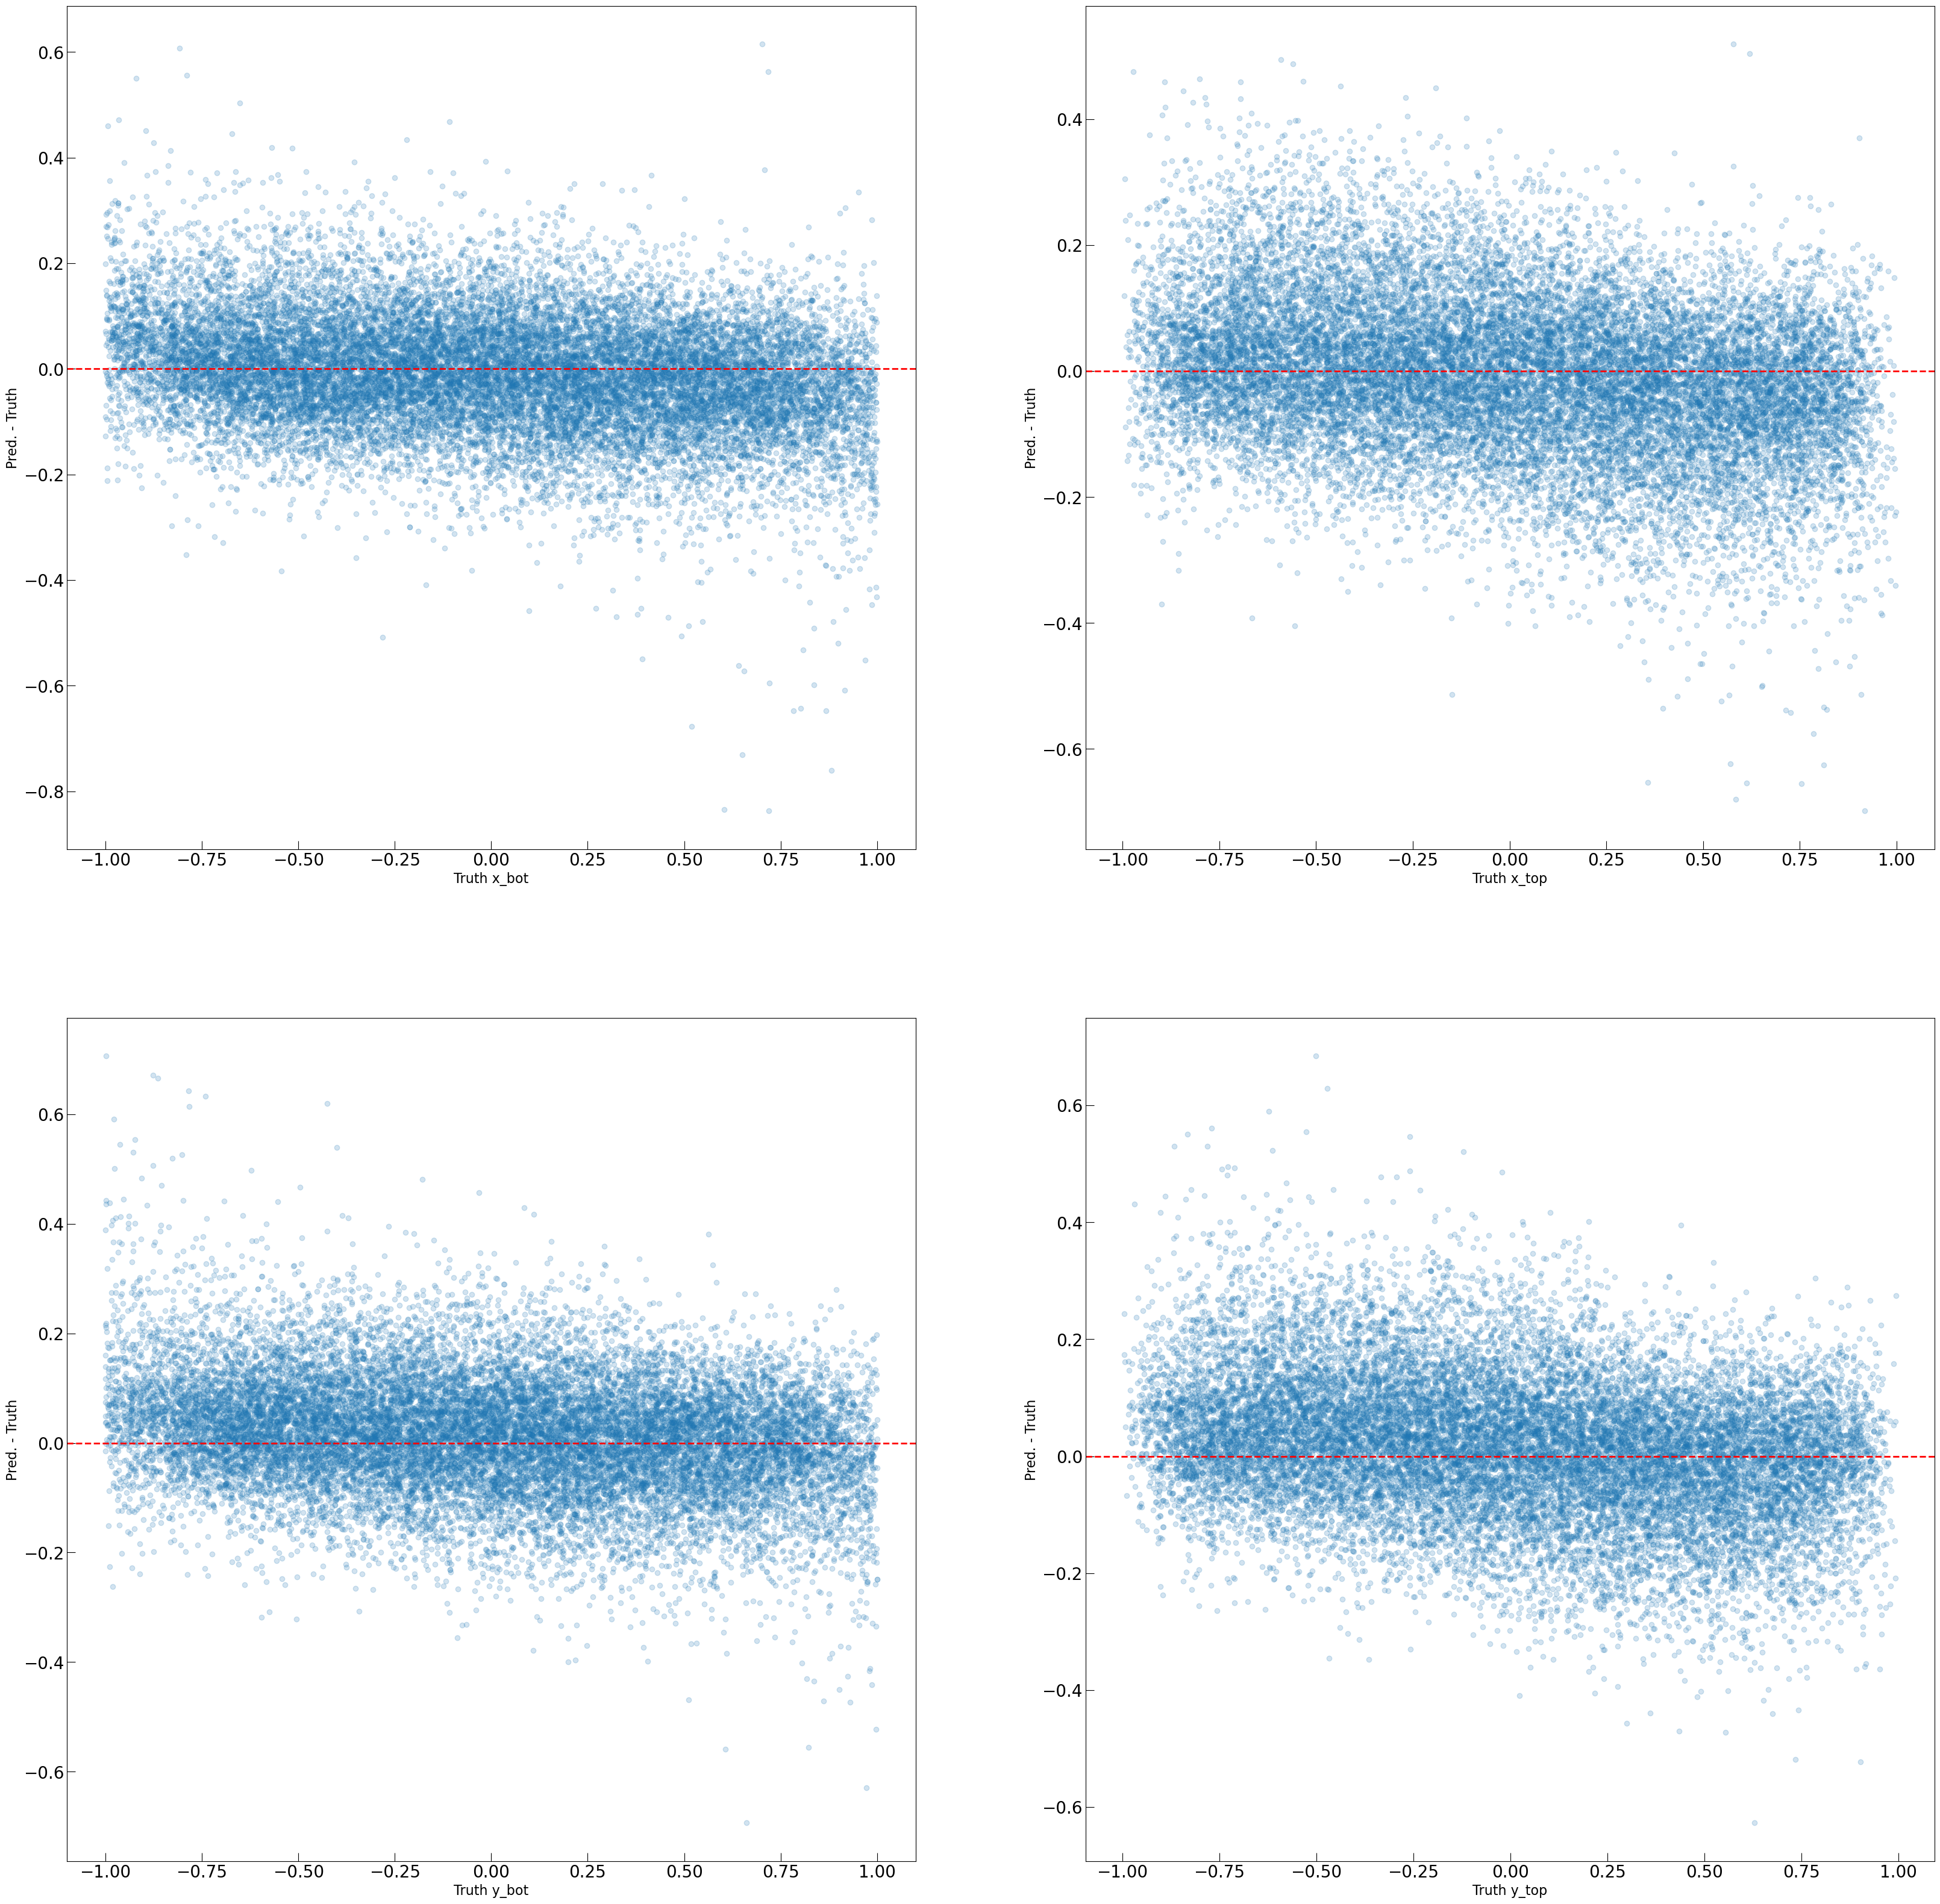

In [30]:
fig = plotting.plot_bias_truth(pred_coords, trial_coords, var_label=labels)

plt.show()
fig.clf()

### Plot the co-ordinates as a 2D histogram

/var/folders/gd/ddv3zxnd0fx9cx3cw9zc9jbw0000gn/T/ipykernel_27310/253545691.py:9: UserWarning: Adding colorbar to a different Figure <Figure size 1400x1200 with 2 Axes> than <Figure size 4000x4000 with 0 Axes> which fig.colorbar is called on.
  fig.colorbar(h[3], ax=ax)


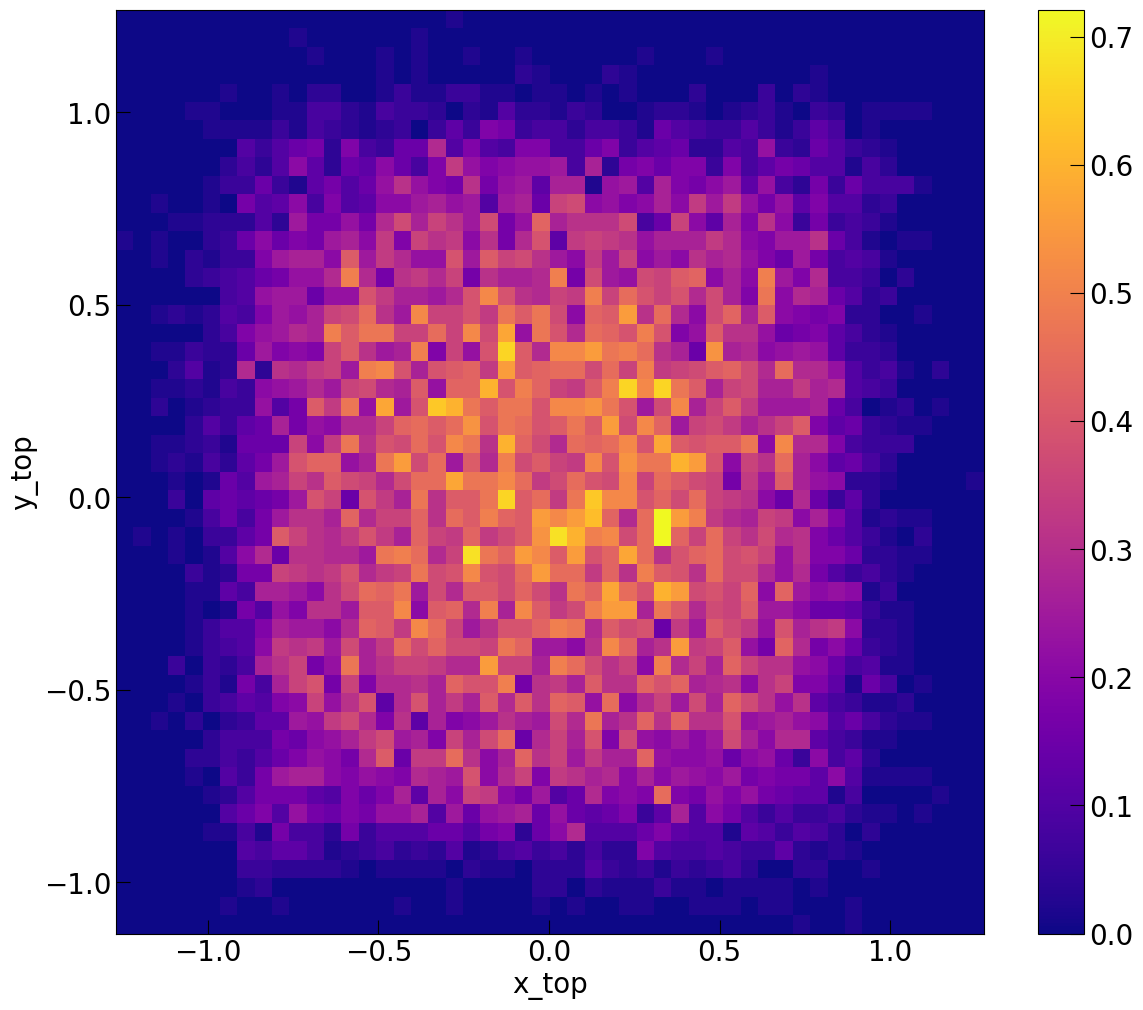

In [31]:
fix, ax = plt.subplots(figsize=(14,12))

h = ax.hist2d(pred_coords[:, 1], pred_coords[:, 3], 
              bins=50, cmap='plasma', 
              density=True, 
              cmin=0.0, cmax=1.0)
ax.set_xlabel('x_top')
ax.set_ylabel('y_top')
fig.colorbar(h[3], ax=ax)
plt.show()

/var/folders/gd/ddv3zxnd0fx9cx3cw9zc9jbw0000gn/T/ipykernel_27310/737819261.py:9: UserWarning: Adding colorbar to a different Figure <Figure size 1400x1200 with 2 Axes> than <Figure size 4000x4000 with 0 Axes> which fig.colorbar is called on.
  fig.colorbar(h[3], ax=ax)


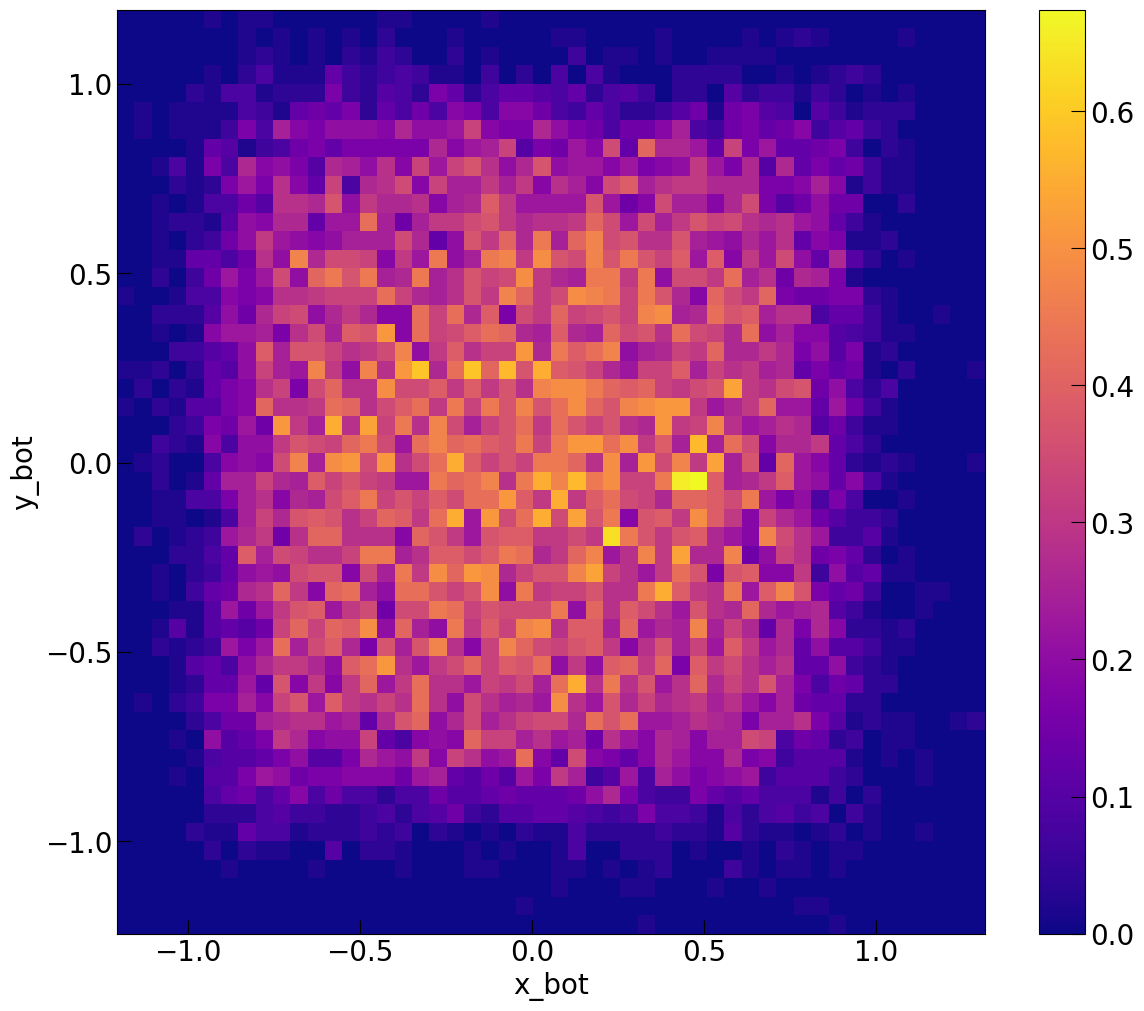

In [32]:
fix, ax = plt.subplots(figsize=(14,12))

h = ax.hist2d(pred_coords[:, 0], pred_coords[:, 2], 
              bins=50, cmap='plasma', 
              density=True,
              cmin=0.0, cmax=1.0)
ax.set_xlabel('x_bot')
ax.set_ylabel('y_bot')
fig.colorbar(h[3], ax=ax)
plt.show()

## Save model

In [34]:
model.save("cnn_2024_10_31.keras")